In [1]:
import pandas as pd
import maidenhead as mh
import numpy as np
import os
from datetime import datetime
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

BRAINS_CSV = '/usr/datalake/silver/stormevents/artifacts/igra_storm_event_autoencoder/brains_station_list.csv'
SEVERE_CSV = '/usr/datalake/silver/stormevents/csvfiles/severe_maidenhead.csv'
IGRA_CSV_PATTERN = '/usr/datalake/silver/stormevents/igra_encoded/{station_id}_igra_encoded.csv'
IGRA_MAIDENHEAD_PATH = '/usr/datalake/silver/stormevents/csvfiles/igra_maidenhead'
MAIDENHEAD = 'EN35'
start_date = datetime(1990, 1, 1)
stop_date = datetime(2025, 5, 30)

In [2]:
os.makedirs(IGRA_MAIDENHEAD_PATH, exist_ok=True)

In [3]:
def get_stations() -> pd.DataFrame:
    result = pd.read_csv(BRAINS_CSV)

    return result

def haversine_distance(lat1: float, lon1: float, lat2: float, lon2: float, earth_radius=6371.0): # Earth radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = earth_radius * c
    return distance

def get_closest_stations(lat: float, lon: float, df_source: pd.DataFrame, limit: int) -> tuple[list[str], list[str]]:
    result = df_source.copy()
    result['distance'] = result.apply(lambda x: haversine_distance(x.latitude, x.longitude, lat, lon), axis=1)
    result = result.sort_values(by='distance')
    result = result.iloc[0:limit]

    names = result.apply(lambda x: f'{x['name']} ({x['id']})', axis=1).to_numpy()
    ids = result['id'].to_numpy()

    return ids, names

def read_igra_by_id(station_id: str) -> pd.DataFrame:
    filename = IGRA_CSV_PATTERN.replace('{station_id}', station_id)
    result = pd.read_csv(filename)
    result['effective_date'] = pd.to_datetime(result['effective_date'])

    return result

def get_column_names():
    result = [f'{i}' for i in range(-1, 61)]
    result[0] = 'effective_date'
    result = np.array(result)

    return result

def merge_closest_igras(station_ids: list[str]) -> pd.DataFrame:
    df_igra = [read_igra_by_id(station_ids[i]) for i in range(3)]

    result = pd.merge(left=df_igra[0], right=df_igra[1], how="inner", left_on='effective_date', right_on='effective_date')
    result = pd.merge(left=result, right=df_igra[2], how="inner", left_on='effective_date', right_on='effective_date')
    result = result.drop(labels=['day_num', 'day_num_y'], axis=1)
    result.columns = get_column_names()

    return result

def get_severe_in_maidenheads(df_source: pd.DataFrame, in_list: list[str]) -> pd.DataFrame:
    result = df_source.copy()
    result['EFFECTIVE'] = pd.to_datetime(result['EFFECTIVE'])
    result = result[result['MAIDENHEAD'].isin(in_list)]
    result = result.drop(labels=['MAIDENHEAD'], axis=1)
    result = result.groupby(by=['EFFECTIVE']).max()

    return result

def merge_temporal_severe(df_source: pd.DataFrame, start: datetime, stop: datetime):
    result = pd.DataFrame(pd.date_range(start, stop), columns=['effective'])
    result = result.merge(df_source, how='left', left_on=['effective'], right_on=['EFFECTIVE'])
    result = result.fillna(0)
    result['LABEL'] = result['LABEL'].astype(int)

    return result

def merge_severe_igra(features: pd.DataFrame, labels: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    merged = features.merge(labels, how='inner', left_on=['effective_date'], right_on=['effective'])
    merged = merged.drop(labels=['effective', 'effective_date'], axis=1)
    feature_result = merged.iloc[:,:-1]
    label_result = merged.iloc[:,-1:]

    return feature_result, label_result

def undersample_non_severe(x: pd.DataFrame, y: pd.DataFrame, threshold: int) -> tuple[pd.DataFrame, pd.DataFrame]:
    n_count = y['LABEL'].value_counts().to_dict()
    if n_count[0] <= threshold:
        return x, y
    n_count[0] = threshold

    rus = RandomUnderSampler(sampling_strategy=n_count)
    r_x, r_y = rus.fit_resample(x, y)

    return r_x, r_y

def oversample_severe(x: pd.DataFrame, y: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    rus = SMOTE()
    r_x, r_y = rus.fit_resample(x, y)

    return r_x, r_y

In [4]:
df_stations = get_stations()
df_stations.head()

,id,latitude,longitude,elevation,state,name,fst_year,lst_year,nobs
0,BBM00078954,13.0716,-59.4922,56.6,NaN,GRANTLEY ADAMS,1965,2025,31817
1,BHM00078583,17.5333,-88.3000,5.0,NaN,BELIZE/PHILLIP GOLDSTON INTL.,1980,2025,21481
2,CJM00078384,19.2944,-81.3632,3.0,NaN,OWEN ROBERTS AIRPORT GRAND CAY,1956,2025,37597
3,COM00080001,12.5833,-81.7167,1.0,NaN,SAN ANDRES (ISLA)/SESQUICENTEN,1956,2025,27604
4,DRM00078486,18.4734,-69.8705,14.0,NaN,SANTO DOMINGO (78486-0),1962,2025,28418


In [5]:
lat, lon = mh.to_location(MAIDENHEAD, True)
print (f'Maidenhead {MAIDENHEAD}: ({lat:.2f}, {lon:.2f})')

Maidenhead EN35: (45.50, -93.00)


In [6]:
station_ids, station_names = get_closest_stations(lat, lon, df_stations, 3)
print(f'Closest stations: {', '.join(station_names)}')

Closest stations: CHANHASSEN; MN. (USM00072649), INT.FALLS/FALLS INT. MN. (USM00072747), GREEN BAY/A.-STRAUBEL; WI. (USM00072645)


In [7]:
df_original_features = merge_closest_igras(station_ids)
df_original_features.head()

,effective_date,0,1,2,3,4,5,6,7,8,...,51,52,53,54,55,56,57,58,59,60
0,1995-08-01,0.84,-0.059983,0.037575,-0.005033,0.004812,-0.229282,-0.271947,0.003661,0.027309,...,-0.134051,-0.045211,-0.017809,0.339644,-0.038558,0.043946,0.252664,-0.089342,0.023288,-0.220279
1,1995-08-04,0.81,-0.114821,0.058322,0.080851,0.025942,-0.258616,-0.156398,0.054782,0.088762,...,-0.165076,0.049192,0.103653,0.421625,-0.027960,0.006994,0.110315,-0.011305,0.014691,-0.255837
2,1995-08-05,0.80,-0.059980,0.112072,-0.134755,0.010958,-0.286056,-0.294404,-0.182463,0.095058,...,-0.122604,-0.114141,-0.077335,0.315262,0.107878,0.026567,-0.038242,0.067160,0.152877,-0.167743
3,1995-08-06,0.79,0.125703,0.092366,0.113854,-0.044687,-0.054590,-0.041724,0.036243,0.193153,...,-0.146776,-0.331121,0.354111,0.407907,-0.029093,0.728276,0.136261,0.139879,-0.014622,-0.029281
4,1995-08-07,0.78,-0.016320,-0.031857,-0.069909,0.013703,-0.334628,-0.040170,0.040049,0.085415,...,-0.189680,0.015369,0.047848,0.470848,-0.090305,0.175331,-0.026512,0.014984,0.050689,-0.029344


In [8]:
df_original_labels = get_severe_in_maidenheads(pd.read_csv(SEVERE_CSV), [MAIDENHEAD])
df_original_labels = merge_temporal_severe(df_original_labels, start_date, stop_date)
df_original_labels.head()

,effective,LABEL
0,1990-01-01,0
1,1990-01-02,0
2,1990-01-03,0
3,1990-01-04,0
4,1990-01-05,0


In [9]:
df_features, df_labels = merge_severe_igra(df_original_features, df_original_labels)
print(f"df_features: {df_features.shape}, df_labels: {df_labels.shape}")

df_features: (7775, 61), df_labels: (7775, 1)


In [10]:
df_labels['LABEL'].value_counts().to_dict()

{0: 7571, 1: 171, 2: 33}

Label count before balancing


array([[<Axes: title={'center': 'LABEL'}>]], dtype=object)

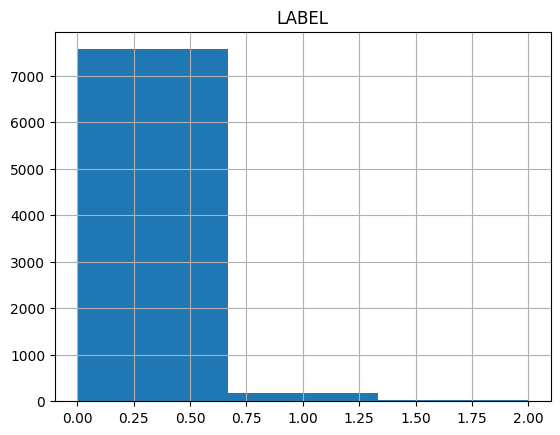

In [11]:
print('Label count before balancing')
df_labels.hist(bins=3)

In [12]:
df_balanced_features, df_balanced_labels = undersample_non_severe(df_features, df_labels, 2000)
df_balanced_features, df_balanced_labels = oversample_severe(df_balanced_features, df_balanced_labels)

In [13]:
print('Label count after balancing')
df_balanced_labels['LABEL'].value_counts().to_dict()

Label count after balancing


{0: 2000, 1: 2000, 2: 2000}

In [14]:
df_merged = pd.concat([df_balanced_features, df_balanced_labels], axis=1)
df_merged.shape

(6000, 62)

In [15]:
df_merged.to_csv(f'{IGRA_MAIDENHEAD_PATH}/{MAIDENHEAD}.csv', index=False)